# Предобработка файла

Файлы, представленные в задании, слишком большие, и их не получится прочитать сразу и записать в оперативную память. Поэтому будем читать файл session построчно, считывать оттуда песни для каждой сессии прослушивания, потом находить исполнителя этой песни, и уже в новый файл session_preprocessed записывать сессии с авторами. 

In [27]:
from pathlib import Path
file_sessions = Path('ThirtyMusic/relations/sessions.idomaar')
file_tracks = Path('ThirtyMusic/entities/tracks.idomaar')
file_persons = Path('ThirtyMusic/entities/persons.idomaar')
new_file_sessions = Path('ThirtyMusic/sessions_persons.idomaar')

In [2]:
import csv, json, sys

In [3]:
from typing import List
def find_person_id(track_id: int, tracks_data: List[List[str]]) -> int:
    '''
    Функция для нахождения id исполнителя по id песни. 
    '''
    track_info = tracks_data[track_id][4]
    track_info_dict = json.loads(track_info)
    person_info = track_info_dict['artists'][0]
    return person_info['id']

In [4]:
tracks_data = []
with open(file_tracks, 'r') as f_tracks:
    track_reader = csv.reader(f_tracks, delimiter='\t')
    for track in track_reader:
        tracks_data.append(track)

In [5]:
# Создаём новый файл с сессиями. 
with open(new_file_sessions, 'w') as f:
    pass

In [6]:
csv.field_size_limit(sys.maxsize)
from tqdm import tqdm
with open(file_sessions, 'r') as f_session:
    session_reader = csv.reader(f_session, delimiter='\t')
    for session_line in tqdm(session_reader):
        # Извлекаем информацию о песнях из сессии, находим id исполнителей
        meta_info, tracks_info = session_line[3].split()
        tracks_info_dict = json.loads(tracks_info)
        for tracks in tracks_info_dict['objects']:
            track_id = tracks.get('id')
            person_id = find_person_id(track_id, tracks_data)
            tracks['person_id'] = person_id
        track_info_new = json.dumps(tracks_info_dict)
        session_line_new = session_line.copy()
        session_line_new[3] = meta_info + ' ' + track_info_new
        with open(new_file_sessions, 'a') as f_new:
            session_writer = csv.writer(f_new, delimiter='\t')
            session_writer.writerow(session_line_new)

2764474it [18:29, 2491.49it/s]


# Разобьём теперь датасет 
На train, test, valid. Но для начала надо подготовленный датасет переформатировать в виде набора списков исполнителей, каждый из которой соответствует сессии прослушивания. id сессии не особо нужен, поэтому их можно опустить. Таким образом, каждой сессии будет соответствовать строка с id исполнителей, разделённых пробелами. 

In [7]:
session_in_persons = []
with open(new_file_sessions, 'r') as f_sessions:
    session_reader = csv.reader(f_sessions, delimiter='\t')
    for session in tqdm(session_reader):
        persons_in_cur_sess = list()
        _, session_info = session[3].split(' ', maxsplit=1)
        session_info_dict = json.loads(session_info)
        for tracks in session_info_dict['objects']:
            persons_in_cur_sess.append(str(tracks['id']))
        session_in_persons.append(persons_in_cur_sess)

2764474it [03:53, 11854.04it/s]


Поскольку в дальнейшем будет использоваться gensim, запишем сессии как списки исполнителей. 

In [8]:
len(session_in_persons)

2764474

Данные об исполнителях в каждой конкретной сессии считаны в список списков, где каждый конкретный "подсписок" соответствует определённой сессии прослушивания. 
Теперь разобьём данные на train, test и valid выборку. 
Пропорции выборки (в долях от исходного набора данных): train / test / val = 0.8 / 0.15 / 0.05

In [9]:
from sklearn.model_selection import train_test_split
train_sessions, test_val_sessions = train_test_split(session_in_persons, train_size=0.8)
test_sessions, val_sessions = train_test_split(test_val_sessions, train_size=0.75)
assert len(test_sessions)+len(val_sessions)+len(train_sessions) == len(session_in_persons)

In [10]:
import pickle
train_file = Path('train.pickle')
test_file = Path('test.pickle')
val_file = Path('val.pickle')
with open(train_file, 'wb') as f_train:
    pickle.dump(train_sessions, f_train)
with open(test_file, 'wb') as f_test:
    pickle.dump(test_sessions, f_test)
with open(val_file, 'wb') as f_val:
    pickle.dump(val_sessions, f_val)

Загрузка данных

In [1]:
import pickle
from pathlib import Path

train_file = Path('train.pickle')
test_file = Path('test.pickle')
val_file = Path('val.pickle')

with open(train_file, 'rb') as f_train:
    train_sessions = pickle.load(f_train)
with open(test_file, 'rb') as f_test:
    test_sessions = pickle.load(f_test)
with open(val_file, 'rb') as f_val:
    val_sessions = pickle.load(f_val)

# Метрика
Задача формулируется как построение векторного пространства исполнителей, чтобы похожие исполнители лежали в нём близко. Смысл близости состоит здесь в том, что в достаточном количестве сессий прослушиваний эти исполнители встречались совместно. 
Уместно выбрать метрику из следующих соображений. Пространство векторов построено на train датасете таким образом, что исполнители из одной сессии лежат в нём близко. В таком случае на test и val исполнители должны также лежать рядом. 

Тогда уместно предположить следующую метрику: будем переходить в векторное пространство для каждого токена из train и val датасетов, а потом попарно считать косинусное расстояние между токенами внутри одной сессии. Из полученных чисел будем брать среднее (думаю, здесь подойдёт среднее арифметическое). Если необходимо оценить метрику для набора сессий, будем также брать арифметическое среднее между оценками для каждой конкретной сессии.

Наверное, было бы правильнее считать эту метрику для тренировочного набора сессий прослушиваний, а потом для тестового. Таким образом, можно нормировать тестовый набор данных на тренировочный. 

Upd: Оказалось, что такая метрика работает слишком медленно на целом наборе сессий. Было бы гораздо проще, если брать какую-то долю выборки и по ней оценивать качество. Например, минимальное из 1% выборки и 1000. 

In [2]:
from typing import Union, List
from gensim.models import Word2Vec, TfidfModel
import gensim

In [3]:
from numpy import dot
from numpy.linalg import norm
from itertools import combinations
from random import choices
from tqdm import tqdm

def count_metrics(
    model: gensim.models.word2vec.Word2Vec,
    sessions_list: Union[List[List[str]], List[str]]
) -> float:
    '''
    Функция для оценки работы алгоритма. 
    '''
    cosine_similarities = []
    chosen_sessions = [ses for ses in sessions_list if len(ses)>2]
    for session in tqdm(choices(chosen_sessions, k=min(1000, int(len(chosen_sessions))+1))):
        vectors_in_session, cos_sim_in_ses = [], []
        
        for person in session:
            # В случае, если автора нет в искомых, добавим нулевой вектор.
            # Косинус угла нулевого вектора и любого другого равен нулю. 
            try:
                vectors_in_session.append(model.wv[person])
            except KeyError:
                vectors_in_session.append([0]*model.vector_size)
        for (a, b) in combinations(vectors_in_session, 2):
            if all(a) == 0 or all(b) == 0:
                cos_sim_in_ses.append(0)
            else:
                cos_sim_in_ses.append(dot(a, b)/(norm(a)*norm(b)))
        avg_in_sess = sum(cos_sim_in_ses) / len(cos_sim_in_ses)
        cosine_similarities.append(avg_in_sess)
    return sum(cosine_similarities) / len(cosine_similarities)

# Идея решения
Будем рассматривать задачу как задачу обработки естественного языка (NLP). Это естественно: набор данных был сформирован так, что представляет собой строки, состоящие из токенов (id исполнителей), разделённых пробелами. Для такой задачи естественно в качестве baseline использовать tfidf представление, а для более продвинутой - модель word2veс. 

#  Baseline
Теперь придумаем какой-нибудь бейзлайн. В качестве векторного представления в базовой модели предлагается использовать некое подобие TF-IDF. Идея этого действия в том, чтобы выделять исполнителей, характерных для данной сессии прослушивания, и учитывать общепрослушиваемых исполнителей меньше. 

Метод fit_transform конвертирует набор сессий в матрицу TF-IDF. 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
train_sessions_str = [' '.join(person for person in ses) for ses in train_sessions if len(ses)>=3]
test_sessions_str = [' '.join(person for person in ses) for ses in test_sessions if len(ses)>=3]
val_sessions_str = [' '.join(person for person in ses) for ses in val_sessions if len(ses)>=3]

In [6]:
tfidf_vectorizer = TfidfVectorizer()
vectorized = tfidf_vectorizer.fit_transform(train_sessions_str)

### Затруднения 

Выбранную метрику я придумал для word2vec модели. В ней качество оценивалось как скалярное произведение всех авторов, встречающихся в произведении. Предположение о правильности использования такой метрики базируется на предположении, что все песни в одной сессии должны быть похожи друг на друга. Степень похожести авторов определяется скалярным произведением (то есть косинусом угла между векторами): чем он ближе к 1, тем группы более похожи друг на друга. Таким образом, для каждой сессии получается некоторое число, которое характеризует среднюю похожесть исполнителей. 

Когда мы обучаем word2vec на train выборке, мы получаем это число для выборки, на которой был обучен word2vec. Когда мы прогоняем через функцию метрики тестовую выборку, по отношению указанной метрики на тестовой выборке к метрике на тренировочной выборке можно судить о точности работы word2veс. Это вы увидите ниже.


Однако, в случае tfidf не очень понятно, как применить такую метрику.

### Решение

Буду использовать алгоритм кластеризации на tfidf_vectorizer. 

In [8]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [11]:
Z = linkage(vectorized, method='average', metric='euclidean')

ValueError: setting an array element with a sequence.

In [ ]:
test_vectorized = tfidf_vectorizer.transform(test_sessions_str)
brc.predict(test_vectorized)

# Более продвинутая модель 
Будем использовать word2vec, основываясь на библиотеке gensim. 

In [4]:
from gensim.models import Word2Vec
from gensim.downloader import tempfile

Реализация Word2Vec в библиотеке gensim имеет несколько параметров, которые можно подбирать, и благодаря можно увеличить качество (т.е. метрику, о которой говорилось выше). 
#Параметр min_count отвечает за минимальное количество токенов, с которых сессия будет учитываться в построении модели.
#window отвечает за максимальное расстояние между целевым словом и словами вокруг него. 
#sg отвечает за выбор обучающего алгоритма: в случае =0 это CBOW; =1 это skig gram. CBOW предсказывает текущего исполнителя, исходя из окружающего его контекста. SG действует наоборот: использует текущего исполнителя, чтобы предсказать окружащих.
#size отвечает за размерность векторов представления исполнителей. 

##   Подбор гиперпараметров 
Теперь необходимо подумать, в каких пределах искать гиперпараметры (если тупо гонять по всему доступному диапазону, двух недель не хватит). 
Известно, что Word2Vec обычно берут для size=300 (то есть пространство 300-мерное). При этом размер словаря составляет порядка 10\**8 - 10\**9 слов (смотрите статические корпусы датасеты слов на сайте https://rusvectores.org/ru/models/).
В нашем случае, согласно прилагаемому описанию датасета, артистов 600К (то есть порядка 10\**5). Можно предположить, что для количества векторов, меньшего на 3 порядка, можно также уменьшить размерность пространства по крайней мере в 2 раза. К сожалению, я думал, что найду в интернете совет, насколько примерно необходимо уменьшить размерность векторов при уменьшении количества векторов. 

Буду брать size равным 20, 50, 100, 300. 

### Вычислим средние показатели прослушиваний
Для подбора гиперпараметров посмотрим на показатели прослушивания: каковы средняя длина сессии. 

Моя исходная гипотеза такая: Можно не учитывать сессии, в которых пользователь слушал меньше 7 песен. Это позволит быстрее обучать модель, отбрасывая слишком короткие сессии.  Соответственно, положим параметр min_count=7. Также window стоит положить равным 7. Это позволит быстрее обучать модель, отбрасывая слишком короткие сессии. 

In [39]:
import numpy as np
train_len = np.array([len(session) for session in train_sessions])
test_len = np.array([len(session) for session in test_sessions])
val_len = np.array([len(session) for session in val_sessions])

In [103]:
print(np.min(train_len), np.max(train_len), 
      '{:.3f}'.format(np.mean(train_len)), '{:.3f}'.format(np.std(train_len)),
      np.median(train_len), np.percentile(train_len, 30), np.percentile(train_len, 90),
      np.percentile(train_len, 20), np.percentile(train_len, 75))
print(np.min(test_len), np.max(test_len), 
      '{:.3f}'.format(np.mean(test_len)), '{:.3f}'.format(np.std(test_len)),
      np.median(test_len), np.percentile(test_len, 30), np.percentile(test_len, 90), 
      np.percentile(test_len, 20), np.percentile(test_len, 75))
print(np.min(val_len), np.max(val_len), 
      '{:.3f}'.format(np.mean(val_len)), '{:.3f}'.format(np.std(val_len)),
      np.median(val_len), np.percentile(val_len, 30), np.percentile(val_len, 90),       
      np.percentile(val_len, 20), np.percentile(val_len, 75))

1 4914 11.338 20.753 6.0 3.0 26.0 2.0 13.0
1 4087 11.341 21.557 6.0 3.0 26.0 2.0 13.0
1 1136 11.394 20.525 6.0 3.0 26.0 2.0 13.0


Выше мы построили разные статистические распределения длины сессии. Во-первых, видно, что train, test, val примерно одинаковы и значительно не отличаются друг от друга. Это означает, что разбиение вполне хорошее, и полученные данные могут быть использованы для оценки. 

С другой стороны, по procentile для разных q видно, что значительная часть сессий имеет короткую длину, а медианная длина составляет всего 6 песен. 75% всех сессий имеет длину, меньшую 13 песен. Вполне разумным кажется придумать разные модели для коротких и для длинных прослушиваний.

Построим гистограмму распределения длин сессий прослушивания. 

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt

<a list of 30 Patch objects>

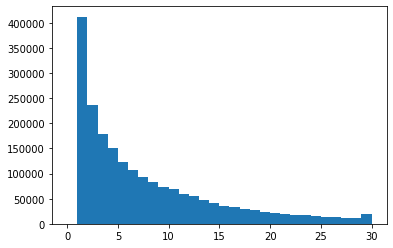

In [145]:
plt.hist(train_len, range=(0, 30), bins=30)[2]

По гистограмме видно, что значительная часть сессий прослушивания (согласно процентилю, около 30%) содержат 3 песни и менее. Я буду полагать, что по таким прослушиваниям нельзя корректно судить о близости разных артистов друг другу. 
#### Таким образом, можно выкинуть все сессии прослушивания короче 3 песен. 

Посмотрим теперь, есть ли среди сессий прослушивания ситуации, когда прослушивается только один артист. Если таких сессий много, их тоже можно выкинуть. 

In [148]:
same_persons_session, same_persons_session_count = [], []

for session in train_sessions:
    if all([session[0]==session[i] for i in range(len(session))]) and len(session) >= 3:
        same_persons_session.append(session[0])
        same_persons_session_count.append(len(session))

len(same_persons_session)

28376

<a list of 30 Patch objects>

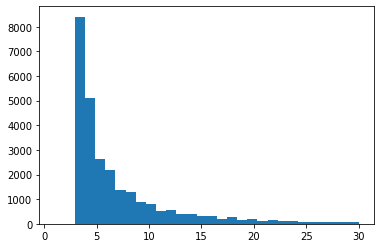

In [149]:
plt.hist(same_persons_session_count, range=(1, 30,), bins=30)[2]

#### Видно, что сессий с одинаковыми прослушиваниями значительно меньше общего числа сессий.
Такие сессии можно оставить, ничего с ними не делая.

In [175]:
from collections import Counter

train_sess_counter = Counter(train_len)
same_per_sess_counter = Counter(same_persons_session_count)
train_same_len_ratio, lengths = [], []

for length in sorted(same_per_sess_counter.keys()):
    lengths.append(length)
    train_same_len_ratio.append(same_per_sess_counter[length] / train_sess_counter[length])

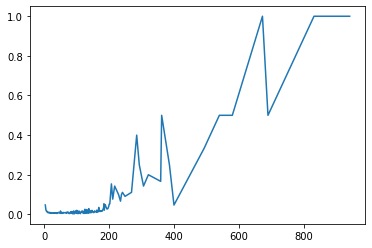

In [178]:
plt.plot(lengths, train_same_len_ratio)
plt.title = 'Зависимость доли прослушиваний одного исполнителя от длины сессии'

Здесь я посчитал долю сессий прослушиваний одного исполнителя для каждой длины сессии. Видно, что для больших длин прослушивания достаточная доля сессий характеризуется прослушиванием песен одного и того же исполнителя. Конечно, здесь есть эффект того, что для больших длин слишком мало сессий, и его тоже надо иметь в виду.  

## Обучим теперь модель (далее параметр size)

# 100

In [179]:
model_100 = Word2Vec(train_sessions, size=100, window=7, min_count=3)
'''
with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model_100.save(temporary_filepath)'''

"\nwith tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:\n    temporary_filepath = tmp.name\n    model_100.save(temporary_filepath)"

In [310]:
train_metrics = count_metrics(model=model_100, sessions_list=train_sessions)

100%|██████████| 1000/1000 [00:11<00:00, 85.45it/s]


In [311]:
test_metrics = count_metrics(model=model_100, sessions_list=test_sessions)

100%|██████████| 1000/1000 [00:09<00:00, 104.60it/s]


In [313]:
test_metrics / train_metrics

0.9204522186136024

# 20

In [314]:
model_20 = Word2Vec(train_sessions, size=20, window=7, min_count=3)

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model_20.save(temporary_filepath)

In [315]:
train_metrics = count_metrics(model=model_20, sessions_list=train_sessions)

100%|██████████| 1000/1000 [00:07<00:00, 125.83it/s]


In [316]:
test_metrics = count_metrics(model=model_20, sessions_list=test_sessions)

100%|██████████| 1000/1000 [00:12<00:00, 77.86it/s]


In [317]:
test_metrics / train_metrics

0.9038636835036806

# 50

In [319]:
model_50 = Word2Vec(train_sessions, size=50, window=7, min_count=3)

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model_50.save(temporary_filepath)

In [320]:
train_metrics = count_metrics(model=model_50, sessions_list=train_sessions)

100%|██████████| 1000/1000 [00:09<00:00, 108.41it/s]


In [321]:
test_metrics = count_metrics(model=model_50, sessions_list=test_sessions)

100%|██████████| 1000/1000 [00:05<00:00, 188.12it/s]


In [322]:
test_metrics / train_metrics

0.9154010214434529

# 300

In [323]:
model_300 = Word2Vec(train_sessions, size=300, window=7, min_count=3)

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model_300.save(temporary_filepath)

In [324]:
train_metrics = count_metrics(model=model_300, sessions_list=train_sessions)

100%|██████████| 1000/1000 [00:27<00:00, 36.01it/s]


In [325]:
test_metrics = count_metrics(model=model_300, sessions_list=test_sessions)

100%|██████████| 1000/1000 [00:26<00:00, 37.33it/s]


In [326]:
test_metrics / train_metrics

0.9016901345544646

# Анализ результатов
Как видно, на выбранной метрике выбранный анализ качества даёт примерно одинаковые результаты (около 90%). Это может означать одну из двух вещей: либо метрика была выбрана неверно, либо увеличение размерности пространства не даёт особого прироста в качестве. Далее мы попробуем найти размерность, ниже которой качество падает. 

# Продолжение

## 10

In [329]:
model_10 = Word2Vec(train_sessions, size=10, window=7, min_count=3)

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model_10.save(temporary_filepath)

In [330]:
train_metrics = count_metrics(model=model_10, sessions_list=train_sessions)

100%|██████████| 1000/1000 [00:04<00:00, 202.86it/s]


In [331]:
test_metrics = count_metrics(model=model_10, sessions_list=test_sessions)

100%|██████████| 1000/1000 [00:05<00:00, 183.49it/s]


In [332]:
test_metrics / train_metrics

0.8777444161184064

## 5

In [341]:
model_5 = Word2Vec(train_sessions, size=5, window=7, min_count=3)

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model_5.save(temporary_filepath)

In [342]:
train_metrics = count_metrics(model=model_5, sessions_list=train_sessions)

100%|██████████| 1000/1000 [00:05<00:00, 180.97it/s]


In [343]:
test_metrics = count_metrics(model=model_5, sessions_list=test_sessions)

100%|██████████| 1000/1000 [00:05<00:00, 167.80it/s]


In [344]:
test_metrics / train_metrics

0.9019749468438251

## 3

In [337]:
model_3 = Word2Vec(train_sessions, size=3, window=7, min_count=3)

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    model_3.save(temporary_filepath)

In [338]:
train_metrics = count_metrics(model=model_3, sessions_list=train_sessions)

100%|██████████| 1000/1000 [00:13<00:00, 72.10it/s]


In [339]:
test_metrics = count_metrics(model=model_3, sessions_list=test_sessions)

100%|██████████| 1000/1000 [00:03<00:00, 258.51it/s]


In [340]:
test_metrics / train_metrics

0.9326022048553768

# Другие гиперпараметры
Как видно, при изменении размерности пространства метрика осталась примерно одинаковой. Возможно, на качество повлияет подбор других гиперпараметров. Поменяем параметр window, влияющий на размер "окна", через которое смотрят на сессии модель. 

# window = 3

In [345]:
model_100_3 = Word2Vec(train_sessions, size=100, window=3, min_count=3)

In [349]:
train_metrics = count_metrics(model=model_100_3, sessions_list=train_sessions)

100%|██████████| 1000/1000 [00:09<00:00, 109.48it/s]


In [350]:
test_metrics = count_metrics(model=model_100_3, sessions_list=test_sessions)

100%|██████████| 1000/1000 [00:10<00:00, 92.35it/s]


In [351]:
test_metrics / train_metrics

0.9054074694652682

# window = 10

In [352]:
model_100_10 = Word2Vec(train_sessions, size=100, window=10, min_count=3)

In [353]:
train_metrics = count_metrics(model=model_100_10, sessions_list=train_sessions)

100%|██████████| 1000/1000 [00:16<00:00, 60.46it/s]


In [354]:
test_metrics = count_metrics(model=model_100_10, sessions_list=test_sessions)

100%|██████████| 1000/1000 [00:13<00:00, 72.43it/s]


In [355]:
test_metrics / train_metrics

0.9351611109243989

## Способ обучения
Попробуем поменять параметр sg. По умолчанию sg=0 - используется CBOW. Положим его равным sg=1, посмотрим, что поменяется. 

In [356]:
model_100_sg = Word2Vec(train_sessions, size=100, window=7, min_count=3, sg=1)

In [357]:
train_metrics = count_metrics(model=model_100_sg, sessions_list=train_sessions)

100%|██████████| 1000/1000 [00:16<00:00, 61.28it/s]


In [358]:
test_metrics = count_metrics(model=model_100_sg, sessions_list=test_sessions)

100%|██████████| 1000/1000 [00:12<00:00, 82.47it/s]


In [359]:
test_metrics / train_metrics

0.8778270381225206

# Узнать соседей
Теперь узнаем соседей по названию музыкальной группы

In [185]:
import csv, json
from pathlib import Path
file_sessions = Path('ThirtyMusic/relations/sessions.idomaar')
file_tracks = Path('ThirtyMusic/entities/tracks.idomaar')
file_persons = Path('ThirtyMusic/entities/persons.idomaar')

In [186]:
persons_dict_by_name = {}
persons_dict_by_id = {}

with open(file_persons, 'r') as f_persons:
    csv_reader = csv.reader(f_persons, delimiter='\t')
    for person in csv_reader:
        person_name = json.loads(person[3])['name']
        person_id = person[1]
        persons_dict_by_name[person_name] = person_id
        persons_dict_by_id[person_id] = person_name

In [242]:
from typing import Dict, Tuple, Union

def get_similar_persons(person_name: str, 
                        neigh_num: int, 
                        persons_dict_by_name: Dict[str, str],
                        persons_dict_by_id: Dict[str, str],
                        model: Union[gensim.models.word2vec.Word2Vec, gensim.models.tfidfmodel.TfidfModel]) -> Tuple[str]:
    '''
    Функция для выведения списка похожих исполнителей. 
    
    Params
    person_name: Название исполнителя
    neigh_num: Количество похожих групп
    person_dict_by_name: Словарь исполнителей. Название : id
    person_dict_by_id: Словарь исполнителей. id: название
    model: 
    '''
    try:
        person_id = persons_dict_by_name[person_name]
    except KeyError:
        return 'No such persons! Please, try again'
    try:
        similars = model.wv.most_similar(person_id, topn=neigh_num)
    except KeyError:
        return 'Sorry, this person is not so popular. We have not found enough sessions with it'
    return [persons_dict_by_id.get(person_id[0]) for person_id in similars]

## Теперь найдём похожих исполнителей

In [243]:
get_similar_persons('Red+Hot+Chili+Peppers%2F12', 20, persons_dict_by_name, persons_dict_by_id, model_100)

['Red+One',
 'Red+Rack%27em',
 'reddmammue',
 'Red+Earth+Collective+meets+Soothsayers+Horns',
 'Red+Red+Wine',
 'Red+Roseland+Cornpickers',
 'Redneck+Girlfriend',
 'Red+City+Radio',
 'Red+Planet',
 'red+rogers',
 'Redeemer+Knoxville+%5Bfeat+Cereus+Bright%5D',
 'Redline+Graffiti',
 'Redbone+(US)',
 'Red+Herring',
 'Red+Garrison+And+His+Zodiacs',
 'Red+Lorry,+Yellow+Lorry',
 'Red+Love',
 'Red+London',
 'Red+Orkestra',
 'Red+Duce']

In [244]:
get_similar_persons('Alla+Pugacheva', 20, persons_dict_by_name, persons_dict_by_id, model_100)

'Sorry, this person is not so popular. We have not found enough sessions with it'

In [245]:
get_similar_persons('Lady+Gaga', 20, persons_dict_by_name, persons_dict_by_id, model_100)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 'Wale%2FCeeLo+Green',
 None,
 None,
 None,
 'That%27s+All+She+Wrote',
 None,
 None,
 None,
 'Ivor+&+The+Engines',
 None,
 'Ari',
 None,
 None]

In [234]:
'Lady+Gaga' in persons_dict_by_name.keys()

True

In [236]:
persons_dict_by_name['Lady+Gaga']

'191173'

In [241]:
[persons_dict_by_id.get(person_id[0]) for person_id in model_100.wv.most_similar('191173')]

[None, None, None, None, None, None, None, 'Wale%2FCeeLo+Green', None, None]

In [240]:
persons_dict_by_id['2801642']

KeyError: '2801642'

## Узнаем, насколько исполнители похожи

In [256]:
def persons_similarity(person_name_1: str,
                       person_name_2: str,
                       persons_dict_by_name: Dict[str, str],
                       persons_dict_by_id: Dict[str, str],
                       model: Union[gensim.models.word2vec.Word2Vec, gensim.models.tfidfmodel.TfidfModel]) -> Tuple[str]:
    '''
    Функция для выведения похожести исполнителей. 
    
    Чем больше, тем более похожи исполнители. 
    
    Params
    person_name_1, person_name_2: Название исполнителей
    person_dict_by_name: Словарь исполнителей. Название : id
    person_dict_by_id: Словарь исполнителей. id: название
    model: 
    '''
    try:
        person_id_1 = persons_dict_by_name[person_name_1]
        person_id_2 = persons_dict_by_name[person_name_2]
    except KeyError:
        return 'No such persons! Please, try again'
    try:
        return model.similarity(person_id_1, person_id_2)
    except KeyError:
        return 'Sorry, this person is not so popular. We have not found enough sessions with it'

In [257]:
persons_similarity('Red+Hot+Chili+Peppers%2F12', 'Lady+Gaga', persons_dict_by_name, persons_dict_by_id, model_100)

/Users/mikhailgashkov/vk/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).


0.6504932

# Вместо вывода

В данном блокноте была решена (или частично решена) задача поиска похожих исполнителей по данным сессиям прослушивания. Не буду ещё раз распространяться, что конкретно было сделано, но мой общий подход к решению был таков, что поиск похожих исполнителей основывается на поиске исполнителей, встречающихся в одинаковых контекстах. С этой точки зрения для поиска похожих исполнителей вполне подойдут контекстуальные эмбеддинги, которые разработаны для задачи анализа естественного языка. 

Спасибо за предоставленную интересную задачу, к сожалению, не всё получилось гладко, но всё же были найдены некоторые похожие исполнители. Для дальнейшего решения данной задачи, как мне кажется, необходимо провести ревизию исполнителей. В данном варианте огромное количество исполнителей повторяются в датасете: они могут записывать как свои сольные работы, так и совместные треки с другими исполнителями, что считается уже отдельным исполнителем. Посмотрев на структуру информации об исполнителях в файле "persons.idomaar", я понял, что быстро эту задачу решить не удастся, а потому не стал её решать. 